In [8]:
import os 
from glob import glob
from functools import reduce 

import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

import xarray as xr
import pandas as pd
import dask

from SALib.analyze import delta

plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.sans-serif"] = "Arial"
plt.rcParams["font.size"] = 12
plt.rcParams["pdf.fonttype"] = 42
plt.rcParams["axes.linewidth"] = 1.50
obs_colors = {'SMAP':"#e7298a", 'VIC':"#d95f02", 'NOAH':"#7570b3", 'MOSAIC':"#1b9e77"}

from matplotlib.colors import LinearSegmentedColormap, ListedColormap

cm_data = np.loadtxt("./utils/colormaps/batlow.txt")[::-1]
sc_cmap = LinearSegmentedColormap.from_list("cmap", cm_data, N=10)

import cartopy.crs as ccrs
import cartopy.feature as cfeature

from utils.global_paths import project_data_path, project_code_path, loca_path

In [2]:
############
### Dask ###
############
from dask_jobqueue import SLURMCluster

cluster = SLURMCluster(
    # account="pches",
    account="open",
    cores=1,
    memory="20GiB",
    walltime="00:10:00"
)
cluster.scale(jobs=10)  # ask for jobs

from dask.distributed import Client
client = Client(cluster)
client

Connection method: Cluster object,Cluster type: dask_jobqueue.SLURMCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.6.0.155:42113,Workers: 0
Dashboard: /proxy/8787/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Preliminaries

In [9]:
# Info 
subset_name = 'eCONUS'
obs_names = list(obs_colors.keys())

# Metrics
soil_metrics = ['mean-anom', '5dmin-anom', '5dmax-anom',
                'mean-change', '5dmin-change', '5dmax-change']

# Soil labels for plots
soil_labels = {"mean-anom": "Annual Average \nSoil Moisture Anomaly", 
               "5dmin-anom": "Soil Moisture Anomaly \nDuring Driest 5 Days",
               "5dmax-anom": "Soil Moisture Anomaly \nDuring Wettest 5 Days",
               "mean-change": "Annual Average \nSoil Moisture Change", 
               "5dmin-change": "Soil Moisture Change \nDuring Driest 5 Days",
               "5dmax-change": "Soil Moisture Change \nDuring Wettest 5 Days"}

# Time slices to analyze
time_slices = [[2030, 2039], [2050,2059], [2080,2089]]

# SSPs
ssps = ['ssp245', 'ssp370']

In [4]:
# Models 
models = os.listdir(f"{loca_path}/")
models.remove('training_data')
models.remove('scripts')

loca_all = {}

# Loop through models
for model in models:
    loca_all[model] = {}
    # Loop through members
    members = os.listdir(f"{loca_path}/{model}/0p0625deg/")
    for member in members:
        # Append SSPs
        ssps = os.listdir(f"{loca_path}/{model}/0p0625deg/{member}/")
        loca_all[model][member] = ssps

# Matches website (https://loca.ucsd.edu/loca-version-2-for-north-america-ca-jan-2023/) as of Jan 2023
print(f"# models: {len(models)}")
print(f"# model/expts: {np.sum([len(np.unique([item for row in [loca_all[model][member] for member in loca_all[model].keys()] for item in row])) for model in models])}")
print(f"# model/expts/ens: {np.sum([len(loca_all[model][ssp]) for model in models for ssp in loca_all[model]])}")
print(f"# model/expts/ens (not including historical): {np.sum([len([ssp for ssp in loca_all[model][member] if ssp != 'historical']) for model in models for member in loca_all[model]])}")

# models: 27
# model/expts: 99
# model/expts/ens: 329
# model/expts/ens (not including historical): 221


In [5]:
# Read all soil moisture metrics
def read_all(subset_name, soil_metric, ssps):
    # For all
    ds_all = []

    # Loop through models
    for model in models:
        # Take first member only
        for member in list(loca_all[model].keys())[:1]:
            # Loop through SSPs
            for ssp in loca_all[model][member]:
                if ssp in ssps:
                    projection_id = f"{model}_{member}_{ssp}"
                    ds_proj = []
                    # Loop through obs
                    for obs_name in obs_names:
                        # Concat along loss metrics
                        ds = xr.open_mfdataset(f"{project_data_path}/projections/{subset_name}/metrics/{soil_metric}/{projection_id}_{obs_name}_*.nc",
                                                combine="nested", concat_dim = "loss_metric")
                        # Append
                        ds_proj.append(ds)
                    # Concat along obs
                    ds_proj = xr.concat(ds_proj, dim="obs_name")
                    ds_all.append(ds_proj)
                    
    # Concat along climate
    ds_all = xr.concat(ds_all, dim="projection_id")

    # Fix time dim
    ds_all['time'] = ds_all['time'].dt.year

    return ds_all

# Delta MIM

## Functions

In [12]:
# # Old function to calculate delta manually
# def get_delta(df_loc, soil_metric, sa_factors):
#     Y = df_loc[soil_metric].to_numpy()
#     Ygrid = np.linspace(np.min(Y), np.max(Y), 100)
#     fy = gaussian_kde(Y, bw_method="silverman")(Ygrid)

#     Si = {}
#     for factor in sa_factors:
#         diffs = []
#         for factor_temp in df_loc[factor].unique():
#             ix = np.argwhere(df_loc[factor] == factor_temp).flatten()
#             fyc = gaussian_kde(Y[ix], bw_method="silverman")(Ygrid)
#             diffs.append(np.trapz(np.abs(fy - fyc), Ygrid))

#         Si[factor] = 0.5 * np.mean(diffs)

#     Si_df = pd.DataFrame.from_dict(Si, orient='index', columns=['delta'])
#     return Si_df

In [58]:
# Reads all .nc projections and stores as parquet file
def store_as_df(subset_name, soil_metric, time_slice):
    # Save path
    save_path = f'{project_data_path}/projections/{subset_name}/metrics_df/{soil_metric}_{time_slice[0]}-{time_slice[1]}'
    
    # Check if done
    if os.path.exists(save_path):
        print('Already done!')
    else:
        # Read all (all SSPs)
        ssps = ['ssp245', 'ssp370']
        ds_all = read_all(subset_name, soil_metric, ssps)

        # Select 
        vars_to_drop = ['projection_id', 'member', 'val_id', 'param_id', 'soil_id']
        with dask.config.set(**{'array.slicing.split_large_chunks': False}):
            df = ds_all.sel(time=slice(time_slice[0], time_slice[1])).drop_vars(vars_to_drop).to_dask_dataframe()

        # Store
        df.to_parquet(save_path, append=False, overwrite=True, compute=True, write_index=False)

In [59]:
# Read specified lat/lon and perfrom delta SA
def get_delta(subset_name, soil_metric, time_slice, lat, lon, sa_factors):
    # Read
    sel = [("lat", "==", lat), ("lon", "==", lon)]
    file_path = f'{project_data_path}/projections/{subset_name}/metrics_df/{soil_metric}_{time_slice[0]}-{time_slice[1]}'
    df_loc = pd.read_parquet(file_path, filters=sel, engine="pyarrow")

    # If needed
    df_loc['soil_id'] = df_loc['obs_name'] + "_" + df_loc['loss_metric']

    # Shuffle for good measure
    df = df_loc.sample(frac=1)

    # Skip if all NaN
    if df.isnull().values.any():
        return None

    # Problem defn
    n_factors = len(sa_factors)
    problem = {
        'num_vars': n_factors,
        'names': sa_factors,
    }

    # Perform SA
    X = df[sa_factors].to_numpy()
    Y = df[soil_metric].to_numpy()
    
    Si = delta.analyze(problem, X, Y, num_resamples=2).to_df()
    Si['lat'] = lat
    Si['lon'] = lon

    Si = Si.reset_index().pivot(index=['lat','lon'], columns='index', values='delta')
    
    return Si

In [80]:
# Perform gridpoint-level delta SA on saved parquet file
def perform_delta_sa(subset_name, soil_metric, time_slice, sa_factors, save_name):
    # Check if done
    save_path = f'{project_data_path}/projections/{subset_name}/sa_results/{soil_metric}_{time_slice[0]}-{time_slice[1]}_delta-sa_{save_name}.nc'
    if os.path.exists(save_path):
        print('Already done!')
        return None
        
    # Get non-NaN locs
    locs = np.load(f"{project_code_path}/code/utils/grids/{subset_name}_non_nans.npy", allow_pickle=True)

    # Loop over all with dask.delayed
    delayed = []

    for loc in locs:
        lat, lon = loc
        df_tmp = dask.delayed(get_delta)(subset_name, soil_metric, time_slice, lat, lon, sa_factors)
        delayed.append(df_tmp)
    
    # Compute
    delayed_out = dask.compute(*delayed)

    # Pandas dataframe 
    df = pd.concat(delayed_out)
    df = df.rename_axis(None, axis=1)

    # Create a complete grid of lat, lon values
    all_lons = ds_all['lon'].to_numpy()
    all_lats = ds_all['lat'].to_numpy()

    lon, lat = np.meshgrid(all_lons, all_lats)
    lon_lat_index = pd.MultiIndex.from_arrays([lat.flatten(), lon.flatten()], names=['lat', 'lon'])

    # Reindex to include all lat, lon combinations, filling missing ones with NaN
    df_reindexed = df.reindex(lon_lat_index)

    # Convert the reindexed DataFrame to an xarray Dataset
    ds = xr.Dataset.from_dataframe(df_reindexed)

    # Store
    ds.to_netcdf(save_path)

## Calculations

In [101]:
# Store non-nan coords for subset if not done already
file_path = f"{project_code_path}/code/utils/grids/{subset_name}_non_nans.npy"

if not os.path.exists(file_path):
    # Read all 
    ds_all = read_all(subset_name, soil_metrics[0], ssps)

    # Get non-nans
    ds_all_stacked = ds_all.stack(loc=['lat','lon']).isel(time=10, projection_id=10, obs_name=0, loss_metric=0)[soil_metrics[0]]
    locs = ds_all_stacked[ds_all_stacked.notnull().compute()]['loc'].to_numpy()

    # Save
    np.save(file_path, locs)

In [103]:
# Store as df
for soil_metric in soil_metrics[:3]:
    for time_slice in time_slices[1:2]:
        store_as_df(subset_name, soil_metric, time_slice)

Already done!
Already done!
Already done!


In [104]:
# Perform SA
for soil_metric in soil_metrics[:3]:
    for time_slice in time_slices[1:2]:
        # All
        sa_factors = ['ssp', 'model', 'time', 'obs_name', 'loss_metric']
        save_name = 'all'
        perform_delta_sa(subset_name, soil_metric, time_slice, sa_factors, save_name)
    
        # Soil grouped
        sa_factors = ['ssp', 'model', 'time', 'soil_id']
        save_name = 'soil_grouped'
        perform_delta_sa(subset_name, soil_metric, time_slice, sa_factors, save_name)

Already done!
Already done!
Already done!
Already done!
Already done!
Already done!


## Plots

### Single gridpoint

In [17]:
# Calculate delta indexes using SAlib
def get_delta_single(df_loc, soil_metric, sa_factors):
    # Shuffle otherwise incorrect
    df = df_loc.sample(frac = 1)
    
    # Problem def
    n_factors = len(sa_factors)
    
    problem = {
        'num_vars': n_factors,
        'names': sa_factors,
    }

    # Do it
    X = df[sa_factors].to_numpy()
    Y = df[soil_metric].to_numpy()
    Si = delta.analyze(problem, X, Y).to_df()
    
    return Si

In [6]:
# Select soil metric
soil_metric = 'mean-change'
soil_label = soil_labels[soil_metric].replace('\n', '')

In [10]:
%%time
# Read all
ds_all = read_all(subset_name, soil_metric, ssps)

CPU times: user 37.7 s, sys: 14.4 s, total: 52 s
Wall time: 1min 18s


In [11]:
%%time
# Get single point: McLean County
lat, lon = 40.61752192312278, -88.68366477345201

df_loc = ds_all.sel(lat=lat, lon=lon, method="nearest")
df_loc = df_loc[soil_metric].to_dataframe().reset_index()

CPU times: user 13.8 s, sys: 817 ms, total: 14.6 s
Wall time: 36 s


In [25]:
# Select time slice
df_sa = df_loc[(df_loc.time >= time_slice[0]) & (df_loc.time <= time_slice[1])]

names = ['ssp', 'model', 'time', 'obs_name', 'loss_metric']

# Get SA indices
Si = get_delta_single(df_sa, soil_metric, names)

In [53]:
# Plotting function
def plot_sa_single(Si, names):

    fig, ax = plt.subplots(1,1, figsize=(6,4), sharey=True)

    fig.suptitle(f"McLean County, Illinois ({time_slice[0]}-{time_slice[1]}) {soil_label}", fontweight='bold', y=0.96)

    # All
    Si.plot.bar(ax=ax, y ='delta', yerr='delta_conf', 
                color=[index_colors[name] for name in names])

    ax.set_ylabel('Delta Sensitivity Index')
    ax.set_xticks(ticks = np.arange(5),
                  labels=[index_labels[name] for name in names],
                  rotation=45)

    custom_lines = [Line2D([0], [0], color=climate_color, lw=4),
                    Line2D([0], [0], color=soil_color, lw=4)]
    ax.legend(custom_lines, ['Climate', 'Soil'])

    ax.grid(alpha=0.5)
    ax.set_axisbelow(True)

    plt.show()

In [54]:
# Plot style
index_labels = {'ssp':'SSP',
                'model':'Climate model',
                'time':'Year',
                'obs_name':'Obs. product',
                'loss_metric':'Loss Function',
                'soil_id':'Soil Parameter'}

index_colors = {'ssp':climate_color,
                'model':climate_color,
                'time':climate_color,
                'obs_name':soil_color,
                'loss_metric':soil_color,
                'soil_id':soil_color}

climate_color = "darkblue"
soil_color = "orange"

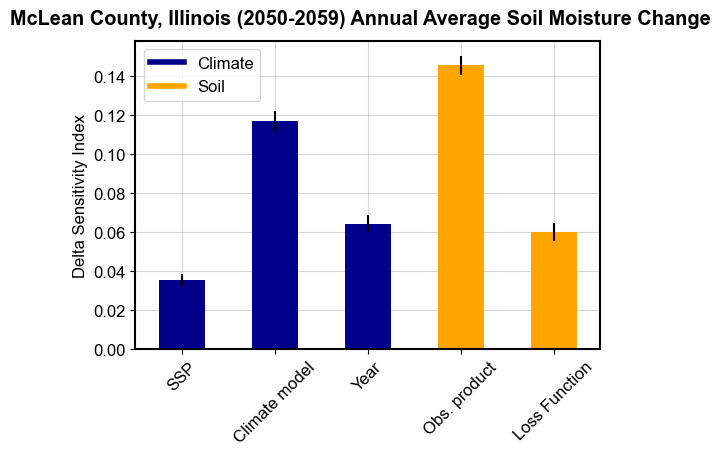

In [55]:
plot_sa_single(Si, names)

### Maps

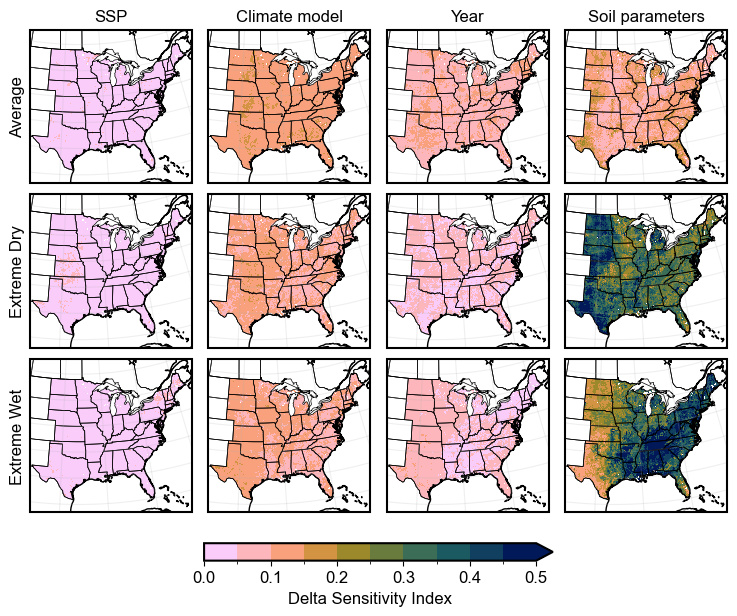

In [29]:
###############
# Soil grouped
###############
# Read all
ds_all = [xr.open_dataset(f'{project_data_path}/projections/eCONUS/sa_results/{soil_metric}_2050-2059_delta-sa_soil_grouped.nc') for soil_metric in soil_metrics]

# Plot
vmax = 0.5
cmap = sc_cmap

sa_factor_names = {'ssp':'SSP', 'model':'Climate model', 'time':'Year', 'soil_id':'Soil parameters'}

fig, axs = plt.subplots(3, 4, figsize=(9, 8), sharex=True, sharey=True,
                   gridspec_kw=dict(wspace=0.1, hspace=0.01),
                   subplot_kw=dict(projection=ccrs.LambertConformal()))

for idx, soil_metric in enumerate(soil_metrics):
    for idf, factor in enumerate(sa_factors):
        # Plot
        ax=axs[idx,idf]
        p = ds_all[idx][factor].plot(ax=ax, vmin=0., vmax=vmax, 
                                     levels=11, cmap=cmap,
                                     add_colorbar=False, transform=ccrs.PlateCarree())
        # Tidy
        ax.coastlines()
        gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
        if idx == 0:
            ax.set_title(sa_factor_names[factor], fontsize=12)

# for ax in axs[-1,:]:
#     gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.left_labels = False

# for ax in axs[:,-1]:
#     gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
#     gl.top_labels = False
#     gl.bottom_labels = False
#     gl.left_labels = False

# Metrics
for idl, soil_label in enumerate(['Average', 'Extreme Dry', 'Extreme Wet']):
    axs[idl,0].text(-0.075, 0.5, soil_label, horizontalalignment='center', fontsize=12,
                    rotation=90, verticalalignment='center', transform=axs[idl,0].transAxes)

# Cbar
fig.colorbar(p,
             orientation="horizontal",
             label="Delta Sensitivity Index",
             ax=axs, pad=0.05, shrink=0.5)

plt.savefig('../figs/sa_all_2050-2059_soil.png', dpi=600, bbox_inches='tight')

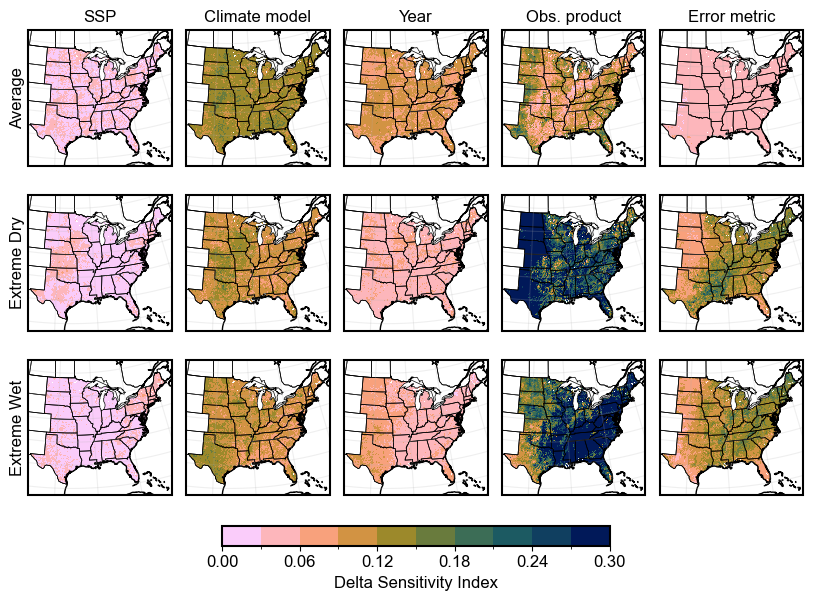

In [56]:
###############
# All
###############
# Read all
ds_all = [xr.open_dataset(f'{project_data_path}/projections/eCONUS/sa_results/{soil_metric}_2050-2059_delta-sa_all.nc') for soil_metric in soil_metrics]

# Plot all
vmax = 0.3
cmap = sc_cmap

sa_factor_names = {'ssp':'SSP', 'model':'Climate model', 'time':'Year', 'obs_name':'Obs. product', 'loss_metric':'Error metric'}

fig, axs = plt.subplots(3, 5, figsize=(10, 8), sharex=True, sharey=True,
                   gridspec_kw=dict(wspace=0.1, hspace=0.01),
                   subplot_kw=dict(projection=ccrs.LambertConformal()))

for idx, soil_metric in enumerate(soil_metrics):
    for idf, factor in enumerate(sa_factors):
        # Plot
        ax=axs[idx,idf]
        p = ds_all[idx][factor].plot(ax=ax, vmin=0., vmax=vmax, 
                                     levels=11, cmap=cmap,
                                     add_colorbar=False, transform=ccrs.PlateCarree())
        # Tidy
        ax.coastlines()
        gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
        if idx == 0:
            ax.set_title(sa_factor_names[factor], fontsize=12)

# for ax in axs[-1,:]:
#     gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
#     gl.top_labels = False
#     gl.right_labels = False
#     gl.left_labels = False

# for ax in axs[:,-1]:
#     gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
#     gl.top_labels = False
#     gl.bottom_labels = False
#     gl.left_labels = False

# Metrics
for idl, soil_label in enumerate(['Average', 'Extreme Dry', 'Extreme Wet']):
    axs[idl,0].text(-0.075, 0.5, soil_label, horizontalalignment='center', fontsize=12,
                    rotation=90, verticalalignment='center', transform=axs[idl,0].transAxes)

# Cbar
fig.colorbar(p,
             orientation="horizontal",
             label="Delta Sensitivity Index",
             ax=axs, pad=0.05, shrink=0.5)

plt.savefig('../figs/sa_all_2050-2059.png', dpi=600, bbox_inches='tight')

### Timeseries and PDFs

In [88]:
# Info
soil_metrics = ['mean-anom', '5dmin-anom', '5dmax-anom']

soil_metric = soil_metrics[2]
soil_label = soil_labels[2].replace('\n', '')
ssps = ['ssp245', 'ssp370']

In [64]:
%%time
ds_all = read_all(subset_name, soil_metric, ssps)

CPU times: user 35 s, sys: 7.14 s, total: 42.2 s
Wall time: 1min 10s


In [65]:
%%time
# Get single point: McLean County
lat1, lon1 = 40.61752192312278, -88.68366477345201

# Get locs
df_loc1 = ds_all.sel(lat=lat1, lon=lon1, method="nearest")
df_loc1 = df_loc1[soil_metric].to_dataframe().reset_index()

CPU times: user 20.4 s, sys: 994 ms, total: 21.4 s
Wall time: 1min 40s


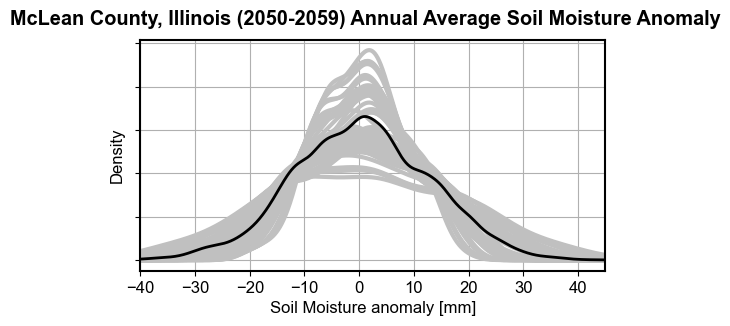

In [16]:
# Single PDF plot
df_plot = df_loc1.query('time >= 2050 and time <= 2059')

fig, ax = plt.subplots(figsize=(6,3), sharex=False, sharey=True)

# Set xlims
xlims = [-40,45]

# Obs name
df_plot.groupby('soil_id')[soil_metric].plot.kde(ax=ax, color='silver', lw=3)

# Add unconditional PDF
df_plot[soil_metric].plot.kde(ax=ax, color='black', lw=2, label="All")
ax.grid()
ax.set_yticklabels([])
ax.set_xlim(xlims)
ax.set_xlabel('Soil Moisture anomaly [mm]')

fig.suptitle(f"McLean County, Illinois (2050-2059) {soil_label}", fontweight='bold', y=0.98)

plt.savefig(f'../figs/il_pdf_{soil_metric}_soil.pdf', bbox_inches='tight')

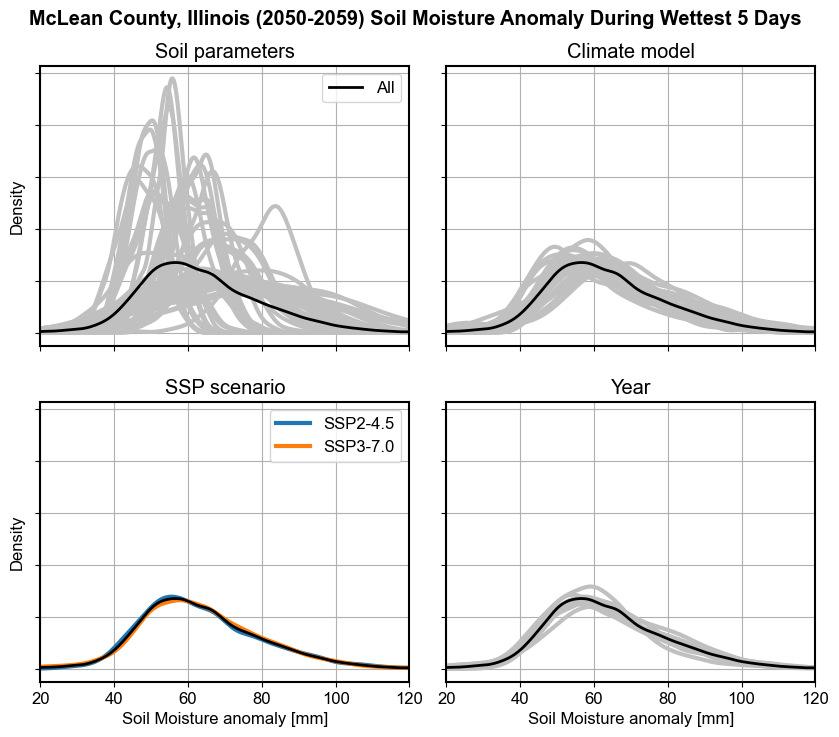

In [68]:
# PDF plot
df_plot = df_loc1.query('time >= 2050 and time <= 2059')

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(10,8), sharex=False, sharey=True, gridspec_kw={'wspace':0.1})
axs=axs.flatten()

# Set xlims
xlims = [20,120]

# Loss metric
ax=axs[0]
ax.set_title('Soil parameters')
df_plot.groupby('soil_id')[soil_metric].plot.kde(ax=ax, lw=3, color='silver')
ax.set_xlim(xlims)
ax.set_xticklabels([])
custom_lines = [Line2D([0], [0], color='black', lw=2)]
ax.legend(custom_lines, ['All'])

# GCM
ax=axs[1]
ax.set_title('Climate model')
df_plot.groupby('model')[soil_metric].plot.kde(ax=ax, lw=3, color='silver')
ax.set_xlim(xlims)
ax.set_xticklabels([])

# SSP
ax=axs[2]
ax.set_title('SSP scenario')
for ssp, group in df_plot.groupby('ssp'):
    ssp_name = f"SSP{ssp[3]}-{ssp[4]}.{ssp[5]}"
    group[soil_metric].plot.kde(ax=ax, lw=3, label=ssp_name)
ax.legend()
ax.set_xlim(xlims)
ax.set_xlabel('Soil Moisture anomaly [mm]')

# Time
ax=axs[3]
ax.set_title('Year')
df_plot.groupby('time')[soil_metric].plot.kde(ax=ax, lw=3, color='silver')
ax.set_xlim(xlims)
ax.set_xlabel('Soil Moisture anomaly [mm]')

# Add unconditional PDF
for ax in axs:
    df_plot[soil_metric].plot.kde(ax=ax, color='black', lw=2)
    ax.grid()
    ax.set_yticklabels([])

fig.suptitle(f"McLean County, Illinois (2050-2059) {soil_label}", fontweight='bold', y=0.95)

plt.savefig(f'../figs/il_pdf_{soil_metric}.pdf', bbox_inches='tight')

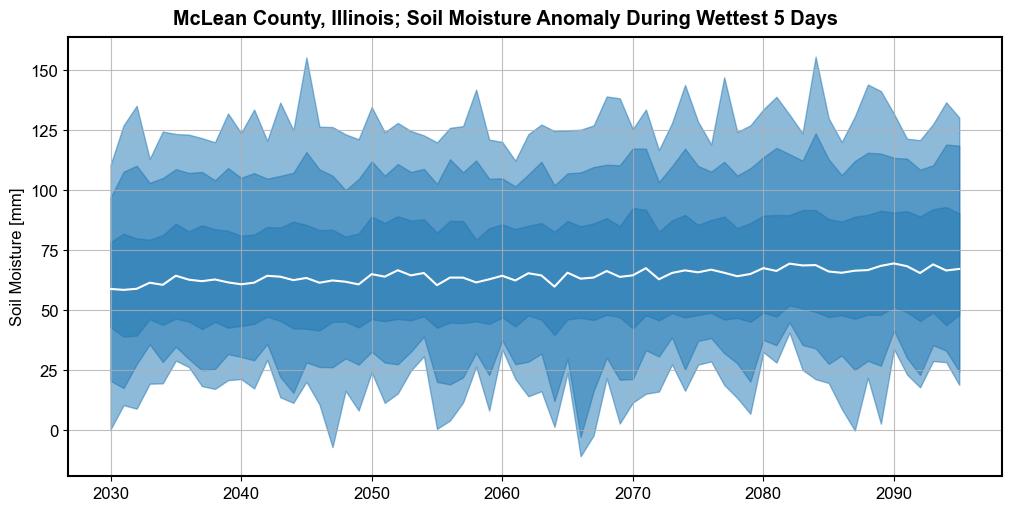

In [69]:
### Timeseries plot
soil_metric_name = 'Soil Moisture [mm]'

fig, ax = plt.subplots(1,1, figsize=(10,5), sharex=True, sharey=True, layout='constrained')
# axs = axs.flatten()

fig.suptitle(f"McLean County, Illinois; {soil_label}", fontweight='bold')

df_plot = df_loc1[(df_loc1['time'] >= 2030) & (df_loc1['time'] <= 2095)]

times = df_plot['time'].unique()

ax.fill_between(times,
                df_plot.groupby('time')[soil_metric].quantile(0.9),
                df_plot.groupby('time')[soil_metric].quantile(0.1),
                alpha=0.5, color='C0')

ax.fill_between(times,
                df_plot.groupby('time')[soil_metric].quantile(0.99),
                df_plot.groupby('time')[soil_metric].quantile(0.01),
                alpha=0.5, color='C0')

ax.fill_between(times,
                df_plot.groupby('time')[soil_metric].max(),
                df_plot.groupby('time')[soil_metric].min(),
                alpha=0.5, color='C0')

ax.plot(times, df_plot.groupby('time')[soil_metric].mean(),
        color='white')

ax.set_ylabel(soil_metric_name)
ax.grid(alpha=0.8)

plt.savefig(f'../figs/il_ts_{soil_metric}.pdf', bbox_inches='tight')

In [46]:
# ### Timeseries plot
# soil_metric_name = 'Soil Moisture [mm]'

# fig, ax = plt.subplots(1,1, figsize=(10,5), sharex=True, sharey=True, layout='constrained')
# # axs = axs.flatten()

# fig.suptitle(f"McLean County, Illinois; {soil_label}", fontweight='bold')

# for idx, obs_name in enumerate(obs_names):
#     # ax=axs[idx]
#     # Subset time and obs
#     df_sel = df_loc1[df_loc1['obs_name'] == obs_name]
#     df_sel = df_sel[(df_sel['time'] >= 2030) & (df_sel['time'] <= 2095)]
    
#     # Individual projections
#     for projection_id in df_sel['projection_id'].unique():
#         for soil_id in df_sel['soil_id'].unique():
#             df_plot = df_sel[(df_sel['projection_id'] == projection_id) & (df_sel['soil_id'] == soil_id)]
#             df_plot = df_plot.sort_values('time')
#             ax.plot(df_plot['time'], df_plot[soil_metric], color='silver', alpha=0.5)
    
#     # # Individual projections
#     # for iss, ssp in enumerate(['ssp245','ssp370']):
#     #     # Model mean
#     #     for model in df_sel['model'].unique():
#     #         df_plot = df_sel[(df_sel['model'] == model) & (df_sel['ssp'] == ssp)].groupby('time')[soil_metric].mean().reset_index()
#     #         df_plot = df_plot.sort_values('time')
#     #         ax.plot(df_plot['time'], df_plot[soil_metric], color=f'C{iss}', alpha=0.9)

#     # Tidy
#     # ax.set_title(obs_name)
#     ax.set_ylabel(soil_metric_name)
#     ax.grid(alpha=0.8)

# # axs[1].set_ylabel('')
# # custom_lines = [Line2D([0], [0], color='C0', lw=2),
# #                Line2D([0], [0], color='C1', lw=2)]
# # axs[0].legend(custom_lines, ['SSP2-4.5', 'SSP3-7.0 (climate model means)'],
# #               ncol=2, loc='lower left')

# # axs[3].set_ylabel('')

# # custom_lines = [Line2D([0], [0], color='silver', lw=2)]
# # axs[1].legend(custom_lines, ['All'], loc='lower left')

# plt.savefig(f'../figs/il_ts_{soil_metric}.png', dpi=600, bbox_inches='tight')

# Range UC

## Functions

In [4]:
# Get SA indices measured by range increase
def calculate_SA_indices_increase(ds, year_groups):
    # For results
    ds_out = []

    for year_group in year_groups:
        # Take time slice
        yr_start, yr_end = year_group
        ds_sel = ds.sel(time=slice(yr_start, yr_end))

        # Calculate range changes
        all_dims = ['projection_id', 'obs_name', 'loss_metric', 'time']
        full_range = (ds_sel[soil_metric].max(dim=all_dims) - ds_sel[soil_metric].min(dim=all_dims))

        # Percentage increase due to products
        obs_range = ds_sel[soil_metric].max(dim=['projection_id', 'loss_metric', 'time']) - ds_sel[soil_metric].min(dim=['projection_id', 'loss_metric', 'time'])
        prod_increase = 100*((full_range / obs_range) - 1.).mean(dim="obs_name")
        
        # Percentage increase due to loss functions
        rmse_range = ds_sel[soil_metric].sel(loss_metric = 'rmse').max(dim=['projection_id', 'time']) - ds_sel[soil_metric].sel(loss_metric = 'rmse').min(dim=['projection_id', 'time'])
        loss_increase = 100*((obs_range / rmse_range) - 1.).mean(dim="obs_name")

        # Percentage increase due to both
        combined_increase = 100*((full_range / rmse_range) - 1.).mean(dim="obs_name")
        
        # Merge
        ds_tmp = xr.merge([xr.Dataset({'product':prod_increase}),
                           xr.Dataset({'loss':loss_increase}),
                          xr.Dataset({'combined':combined_increase})])
        ds_tmp = ds_tmp.assign_coords(time=yr_end)
        ds_out.append(ds_tmp)

    # Concat along time
    ds_out = xr.concat(ds_out, dim="time")
    return ds_out.compute()

In [5]:
# Plot range increases for single gridpoint
def plot_ranges_single(df, year_group, soil_metric, ax, ylabels, xlabel, legend, title, colors, lw):
    # Select data
    df_sel = df[(df['time'] >= year_group[0]) & (df['time'] <= year_group[1])]
        
    # Plot full range
    min, max = df_sel[soil_metric].min(), df_sel[soil_metric].max()
    # min, max = np.quantile(df_sel[soil_metric], 0.005), np.quantile(df_sel[soil_metric], 0.995)
    ax.hlines(y=0, xmin=min, xmax=max, color='black', lw=2)
    ax.scatter([max], [0], marker='>', color='black')
    ax.scatter([min], [0], marker='<', color='black')
    
    # Loop through obs
    for ido, obs_name in enumerate(obs_names):
        # Where to plot
        idloc = 1 + ido
        # RMSE only
        data_rmse = df_sel[(df_sel['loss_metric'] == "rmse") & (df_sel['obs_name'] == obs_name)][soil_metric]
        min, max = data_rmse.min(), data_rmse.max()
        # min, max = np.quantile(data_rmse, 0.005), np.quantile(data_rmse, 0.995)
        # mean = data_rmse.mean()
        ax.hlines(y=idloc, xmin=min, xmax=max, color=colors[obs_name], lw=2)
        ax.scatter([min, max], [idloc,idloc], marker='o', color=colors[obs_name])
        ax.scatter([min, max], [idloc,idloc], marker='o', color=colors[obs_name])
        # ax.scatter([mean], [ido], marker='|', color='black')

        # All
        data_all = df_sel[(df_sel['obs_name'] == obs_name)][soil_metric]
        min, max = data_all.min(), data_all.max()
        # min, max = np.quantile(data_all, 0.005), np.quantile(data_all, 0.995)
        # mean = data_all.mean()
        ax.hlines(y=idloc, xmin=min, xmax=max, color=colors[obs_name], ls='--', lw=2)
        ax.scatter([max], [idloc], marker='>', color=colors[obs_name])
        ax.scatter([min], [idloc], marker='<', color=colors[obs_name])
        # ax.scatter([mean], [ido], marker='|', color='black')

    # Tidy
    ax.set_ylim([-0.5,4.5])
    if ylabels:
        ax.set_yticks(ticks=np.arange(5), labels = ['All'] + obs_names)
    else:
        ax.set_yticks(ticks=np.arange(5), labels=['','','',''])
    ax.grid(alpha=0.8)
    ax.set_axisbelow(True)

    # Add legend
    if legend:
        ax.legend([Line2D([0], [0], color='black', lw=2, ls='--'),
                      Line2D([0], [0], color='black', lw=2, ls='-')],
                     ['RMSE', 'All'],
                     loc=legend)

    # Axis label
    ax.set_xlabel(xlabel)
    ax.set_title(title)

In [90]:
def plot_increases(df, year_group, ax, soil_metric, colors, xlabel):
    # Select data
    df_sel = df[(df['time'] >= year_group[0]) & (df['time'] <= year_group[1])]
    
    # Calculate range changes
    all_dims = ['projection_id', 'obs_name', 'loss_metric', 'time']
    full_range = df_sel[soil_metric].max() - df_sel[soil_metric].min()

    # Percentage increase due to products
    obs_range = df_sel.groupby('obs_name')[soil_metric].max() - df_sel.groupby('obs_name')[soil_metric].min()
    prod_increase = 100*((full_range / obs_range) - 1.).mean()
        
    # Percentage increase due to loss functions
    df_rmse = df_sel[df_sel['loss_metric'] == 'rmse']
    rmse_range = df_rmse.groupby('obs_name')[soil_metric].max() - df_rmse.groupby('obs_name')[soil_metric].min()
    loss_increase = 100*((obs_range / rmse_range) - 1.).mean()

    # Percentage increase due to both
    obs_rmse_range = df_rmse.groupby('obs_name')[soil_metric].max() - df_rmse.groupby('obs_name')[soil_metric].min()
    full_increase = 100*((full_range / obs_rmse_range) - 1.).mean()

    # Plot means
    # y1, y2, y3 = 0.25, 0.5, 0.75
    # ax.barh(y1, full_increase, align='center', height=0.15, color='black')

    y1, y2 = 0.25, 0.75
    ax.barh(y1, prod_increase, align='center', height=0.15, color='black')
    ax.barh(y2, loss_increase, align='center', height=0.15, color='black')

    # Plot scatters
    for obs_name in obs_names:
        # ax.scatter(y=0.25, x=(100*((full_range / obs_rmse_range) - 1.))[obs_name], color=colors[obs_name])
        
        ax.scatter(y=0.25, x=(100*((full_range / obs_range) - 1.))[obs_name], color=colors[obs_name])
        ax.scatter(y=0.75, x=(100*((obs_range / rmse_range) - 1.))[obs_name], color=colors[obs_name])

    # Tidy
    ax.set_ylim([0,1])
    ax.grid(alpha=0.8)
    ax.set_axisbelow(True)
    # ax.set_yticks([y1,y2,y3], ['Combined', 'Additional products', 'Additional loss functions'])
    ax.set_yticks([y1,y2], ['Additional products', 'Additional loss functions'])
    if xlabel:
        ax.set_xlabel('Increase in uncertainty (%)')

In [8]:
"""
Uncertainty sources gridpoint
"""
def gridpoint_plot_soil_uc(df, soil_metrics, ssp, year_group, title, save_name):
    
    fig, axs = plt.subplots(2,3, figsize=(14,5), sharey='row', height_ratios=[3,1], gridspec_kw=dict(hspace=0.5))

    fig.suptitle(f'{title}; {ssp} ({year_group[0]}-{year_group[1]})', fontweight='bold', y=1.04)

    # Plot all
    for id, soil_metric in enumerate(soil_metrics):
        # LOC 1
        # Plot ranges
        plot_ranges_single(df=df, 
                       ax=axs[0,id],
                       soil_metric=soil_metric,
                       ylabels=True,
                       xlabel="[mm]",
                       title = soil_labels[id],
                       legend=False,
                       year_group=year_group,
                       colors=obs_colors,
                       lw=2)
        # Plot changes
        plot_increases(df=df,
                   ax=axs[1,id],
                   soil_metric=soil_metric,
                   year_group=year_group,
                   colors=obs_colors,
                   xlabel=True)

    if save_name:
        plt.savefig(f'../figs/{save_name}.pdf', bbox_inches='tight')
    else:
        plt.show()

In [9]:
"""
Uncertainty sources map
"""
def map_plot_soil_uc(ds, soil_metrics, ssp, year_group, save_name, vmax = 200., cmap = sc_cmap):
    # Otherwise breaks
    assert len(soil_metrics) == 3

    # Select time
    ds_sel = ds.sel(time=year_group[1])
    
    fig, axs = plt.subplots(2, 3, figsize=(10, 8), sharex=True, sharey=True,
                       gridspec_kw=dict(wspace=0.1, hspace=0.01),
                       subplot_kw=dict(projection=ccrs.LambertConformal()))

    for idx, soil_metric in enumerate(soil_metrics):
        # Loss function
        ax=axs[0,idx]
        p = ds_sel.sel(soil_metric=soil_metric)['loss'].plot(ax=ax, vmin=0., vmax=vmax, 
                                               levels=11, cmap=cmap,
                                               add_colorbar=False, transform=ccrs.PlateCarree())
        # Product
        ax=axs[1,idx]
        p = ds_sel.sel(soil_metric=soil_metric)['product'].plot(ax=ax, vmin=0., vmax=vmax, 
                                                   levels=11, cmap=cmap,
                                                   add_colorbar=False, transform=ccrs.PlateCarree())
    
        # # Combined
        # ax=axs[2,idx]
        # p = ds_sel.sel(soil_metric=soil_metric)['combined'].plot(ax=ax, vmin=0., vmax=vmax, 
        #                                        levels=11, cmap=cmap,
        #                                        add_colorbar=False, transform=ccrs.PlateCarree())
    
    # Tidy
    for ax in axs.flatten():
        ax.coastlines()
        gl = ax.gridlines(draw_labels=False, x_inline=False, rotate_labels=False, alpha=0.2)
        ax.add_feature(cfeature.STATES, edgecolor='black', linewidth=0.5)
        ax.add_feature(cfeature.BORDERS, edgecolor='black', linewidth=0.5)
        ax.set_extent([-106, -73, 23, 51], ccrs.Geodetic())
        ax.set_title('')

    # Coords for some
    gl = axs[1,2].gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
    gl.top_labels = False
    gl.left_labels = False
    
    for ax in [axs[1,0], axs[1,1]]:
        gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
        gl.top_labels = False
        gl.right_labels = False
        gl.left_labels = False
    
    for ax in [axs[0,2], axs[1,2]]:
        gl = ax.gridlines(draw_labels=True, x_inline=False, rotate_labels=False, alpha=0.3)
        gl.top_labels = False
        gl.bottom_labels = False
        gl.left_labels = False
    
    # Titles
    axs[0,0].set_title(soil_labels[0])
    axs[0,1].set_title(soil_labels[1])
    axs[0,2].set_title(soil_labels[2])
    fig.suptitle(f'{year_group[0]}-{year_group[1]} under {ssp}', fontweight='bold', y=0.94)
    
    # Label
    axs[0,0].text(-0.05, 0.5, 'Loss Functions', horizontalalignment='center', fontsize=14,
                  rotation=90, verticalalignment='center', transform=axs[0,0].transAxes)
    
    axs[1,0].text(-0.05, 0.5, 'Products', horizontalalignment='center', fontsize=14,
                  rotation=90, verticalalignment='center', transform=axs[1,0].transAxes)
    
    # axs[2,0].text(-0.05, 0.5, 'Combined', horizontalalignment='center', fontsize=14,
    #               rotation=90, verticalalignment='center', transform=axs[2,0].transAxes)
    
    # Cbar
    fig.colorbar(p,
                 orientation="horizontal",
                 label="Average Increase in Uncertainty (%)",
                 ax=axs, pad=0.06, shrink=0.5)
    
    if save_name:
        plt.savefig(f'../figs/{save_name}.png', dpi=600, bbox_inches='tight')
    else:
        plt.show()

In [10]:
# def plot_ranges_time(df, ax, ylabels, xlabel, legend):
#     # For time evolution
#     colors = ["#b3cde3", "#8c96c6", "#88419d"]
#     for idt, year_group in enumerate(year_groups):
#         # Select data
#         df_sel = df[(df['time'] >= year_group[0]) & (df['time'] <= year_group[1])]
        
#         # Plot full range
#         min, max = df_sel[soil_metric].min(), df_sel[soil_metric].max()
#         ax.hlines(y=-idt/4, xmin=min, xmax=max, color=colors[idt])
#         ax.scatter([max], [-idt/4], marker='>', color=colors[idt])
#         ax.scatter([min], [-idt/4], marker='<', color=colors[idt])
        
#         # Loop through obs
#         for ido, obs_name in enumerate(obs_names):
#             # Where to plot
#             idloc = 1 + ido - (idt/4)
#             # RMSE only
#             data_rmse = df_sel[(df_sel['loss_metric'] == "rmse") & (df_sel['obs_name'] == obs_name)][soil_metric]
#             min, max = data_rmse.min(), data_rmse.max()
#             # mean = data_rmse.mean()
#             ax.hlines(y=idloc, xmin=min, xmax=max, color=colors[idt])
#             ax.scatter([min, max], [idloc,idloc], marker='o', color=colors[idt])
#             ax.scatter([min, max], [idloc,idloc], marker='o', color=colors[idt])
#             # ax.scatter([mean], [ido], marker='|', color='black')
    
#             # All
#             data_all = df_sel[(df_sel['obs_name'] == obs_name)][soil_metric]
#             min, max = data_all.min(), data_all.max()
#             # mean = data_all.mean()
#             ax.hlines(y=idloc, xmin=min, xmax=max, color=colors[idt], ls='--')
#             ax.scatter([max], [idloc], marker='>', color=colors[idt])
#             ax.scatter([min], [idloc], marker='<', color=colors[idt])
#             # ax.scatter([mean], [ido], marker='|', color='black')
    
#         # Tidy
#         if ylabels:
#             ax.set_yticks(ticks=np.arange(5)-0.25, labels = ['All'] + obs_names)
#         else:
#             ax.set_yticks(ticks=np.arange(5)-0.25, labels=['','','',''])
#         ax.grid(alpha=0.8)

#     # Add legend to one
#     if legend:
#         ax.legend([Line2D([0], [0], color='black', lw=2, ls='--'),
#                       Line2D([0], [0], color='black', lw=2, ls='-')],
#                      ['RMSE', 'All'],
#                      loc=legend)

#     # Axis label
#     ax.set_xlabel(xlabel)


# # For time evolution
# colors = ["#b3cde3", "#8c96c6", "#88419d"]
# colors = ['C0']

# fig, axs = plt.subplots(1,2, figsize=(8,5), sharey=True)

# # NE
# ax=axs[0]
# plot_ranges_time(df=df_ne, 
#             ax=ax,
#             ylabels=True,
#             xlabel='Annual Average Soil Moisture [mm]',
#             legend=False)

# # KY
# ax=axs[1]
# plot_ranges_time(df=df_ky, 
#             ax=ax,
#             ylabels=True,
#             xlabel='Annual Average Soil Moisture [mm]',
#             legend='upper right')

# plt.show()

In [15]:
# Select SSP and years
# ssp = 'SSP2-4.5'
ssp = 'SSP3-7.0'
ssp_read = [ssp.lower().replace('.','').replace('-','')]

In [55]:
%%time
# Get all soil metrics
ds_out = []
for soil_metric in soil_metrics:
    ds_all = read_all(subset_name, soil_metric, ssp_read)
    ds_sa = calculate_SA_indices(ds_all, year_groups)
    ds_sa = ds_sa.assign_coords(soil_metric = soil_metric)
    ds_out.append(ds_sa)

# Combine
ds_out = xr.concat(ds_out, dim='soil_metric')

CPU times: user 1min 32s, sys: 12.6 s, total: 1min 45s
Wall time: 2min 23s


## Plots

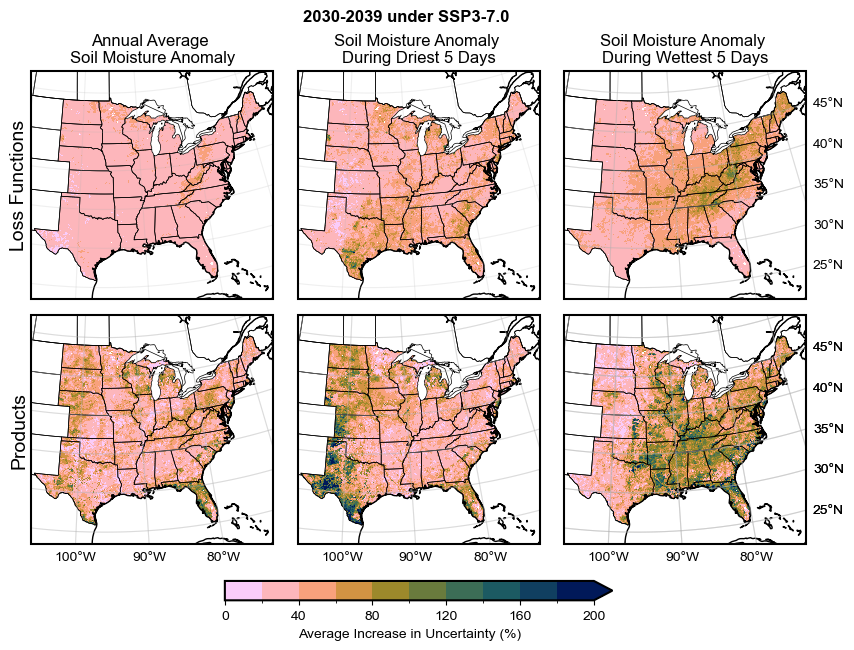

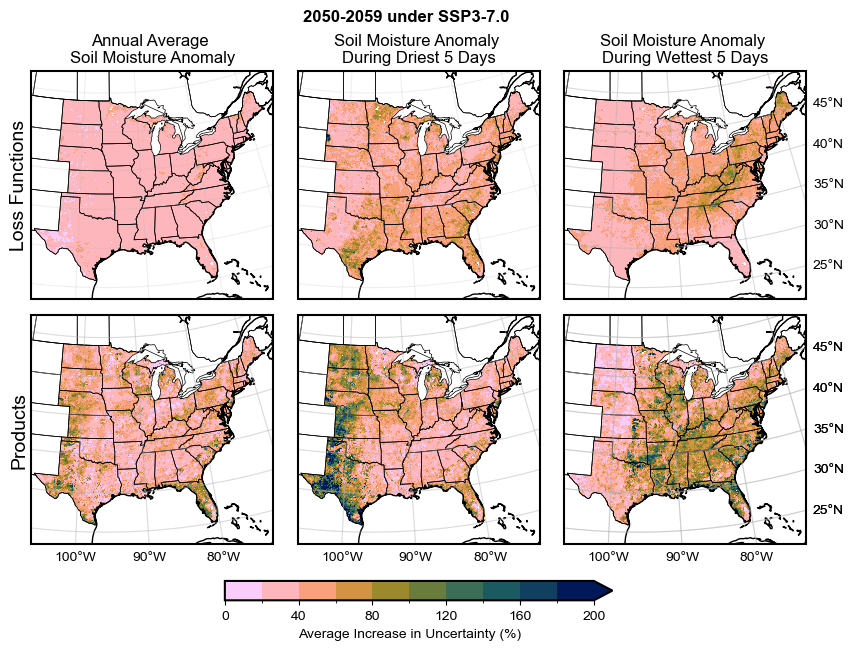

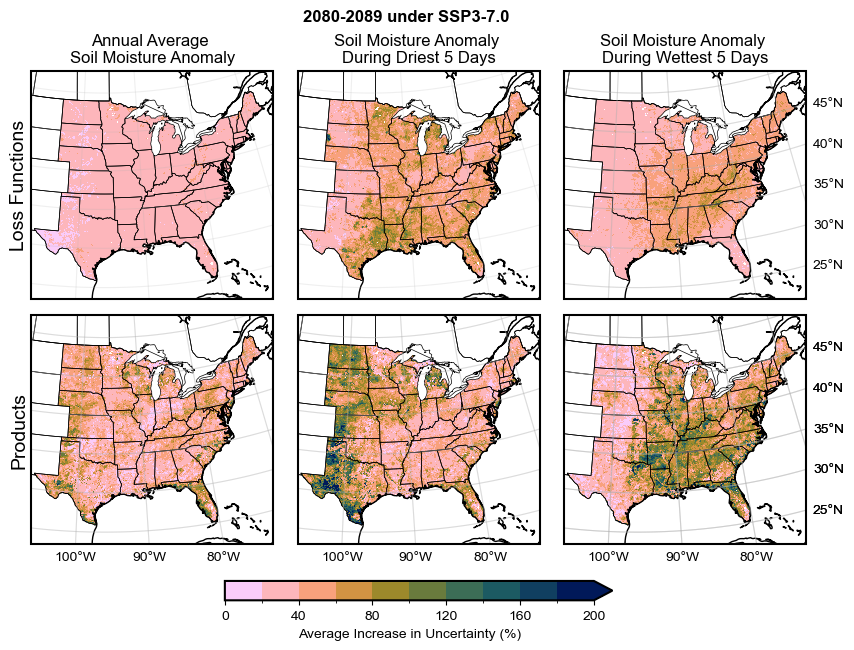

In [56]:
"""
Uncertainty sources map
"""
for year_group in year_groups:
    map_plot_soil_uc(ds_out, soil_metrics, ssp, year_group,
                     save_name=f'map_soil_sa_{ssp_read[0]}_{year_group[0]}-{year_group[1]}')

## Range plots

In [13]:
# Select SSP
# ssp = 'SSP2-4.5'
ssp = 'SSP3-7.0'

ssp_read = [ssp.lower().replace('.','').replace('-','')]

In [15]:
%%time
##### Get all soil metrics
# McLean County IL
lat1, lon1 = 40.61752192312278, -88.68366477345201

df_out_loc1 = []

for soil_metric in soil_metrics:
    # Read all 
    ds_all = read_all(subset_name, soil_metric, ssp_read)

    # Get locs
    df_loc1 = ds_all.sel(lat=lat1, lon=lon1, method="nearest")
    df_loc1 = df_loc1[soil_metric].to_dataframe().reset_index()
    df_out_loc1.append(df_loc1)

# Merge all
df_out_loc1 = reduce(lambda x,y: pd.merge(x,y), df_out_loc1)

CPU times: user 53.8 s, sys: 14 s, total: 1min 7s
Wall time: 2min 5s


In [17]:
soil_labels = ["a) Annual Average \nSoil Moisture Anomaly", 
               "b) Soil Moisture Anomaly \nDuring Driest 5 Days",
               "c) Soil Moisture Anomaly \nDuring Wettest 5 Days"]

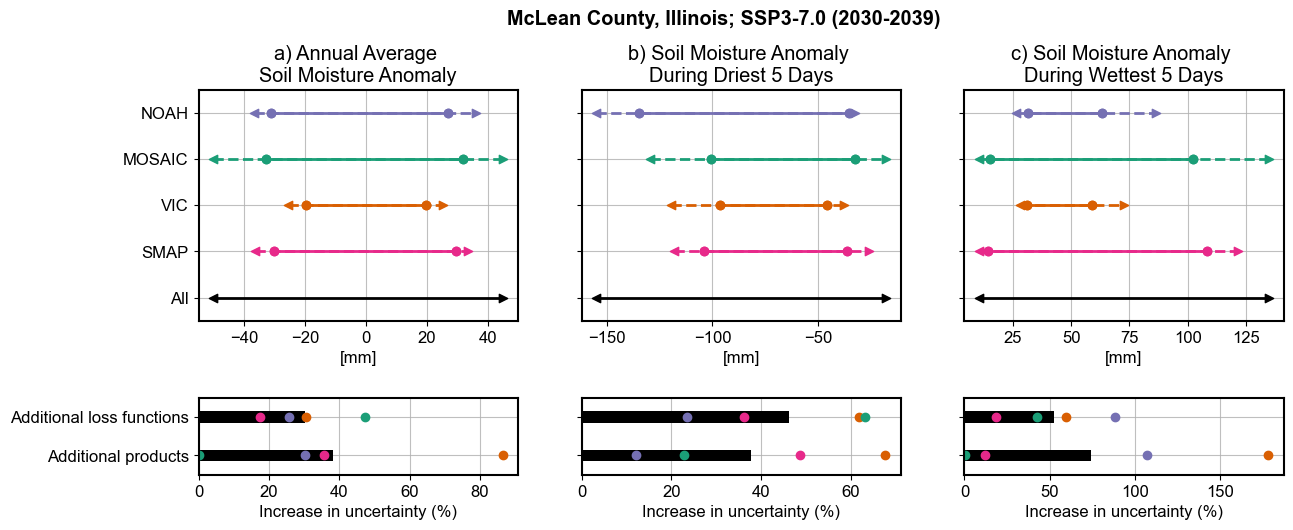

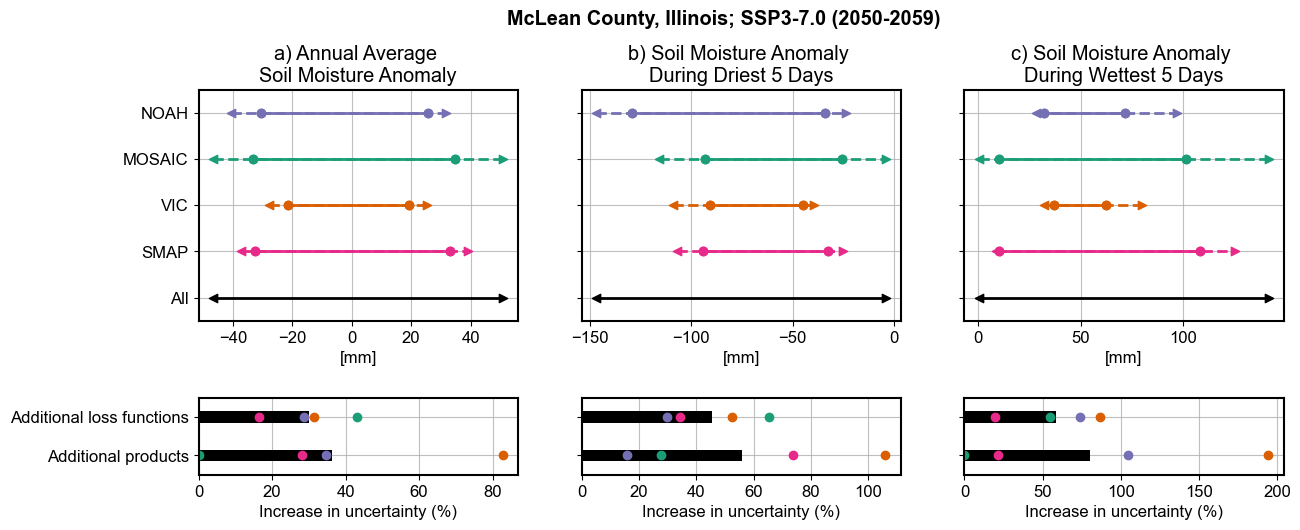

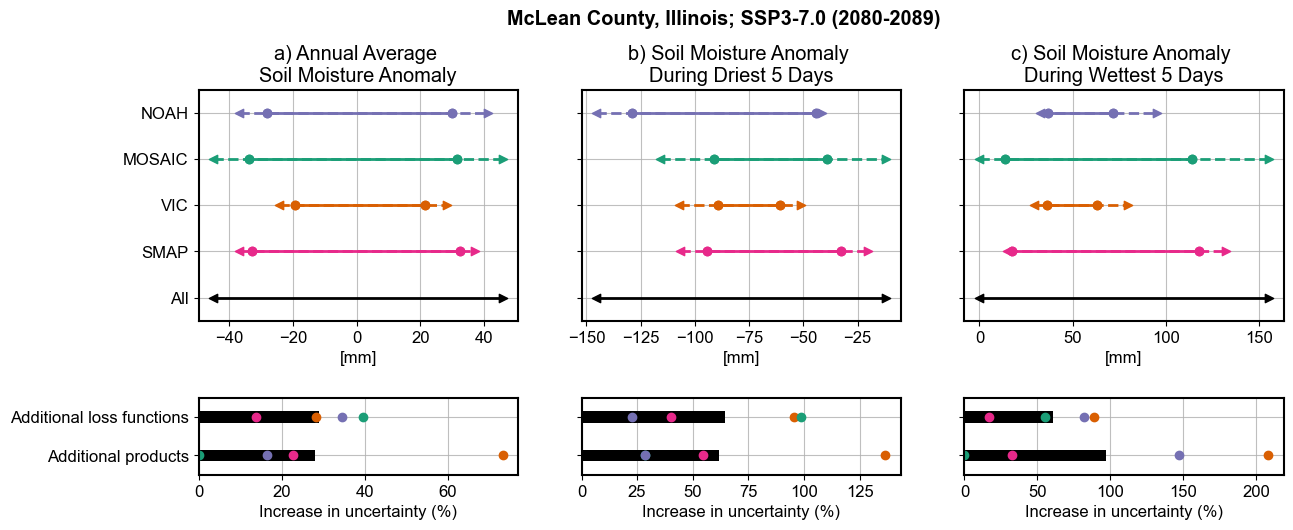

In [18]:
# Plot
title = "McLean County, Illinois"

for year_group in year_groups:
    gridpoint_plot_soil_uc(df_out_loc1, soil_metrics, ssp, year_group, title,
                           save_name=f'il_param_increase_{ssp_read[0]}_{year_group[0]}-{year_group[1]}')

## Old

In [172]:
%%time
##### Get all soil metrics
# West Texas
lat1, lon1 = 31.31305803607532, -102.2111532257517
# West Central Kentucky
lat2, lon2 = 37.33650616215579, -86.51181594341504

df_out_loc1 = []
df_out_loc2 = []

for soil_metric in ['mean', '5dmin', '5dmax']:
    # Read all 
    ds_all = read_all(subset_name, soil_metric, ssps, n_member_min, loss_metrics_drop)

    # Get locs
    df_loc1 = ds_all.sel(lat=lat1, lon=lon1, method="nearest")
    df_loc1 = df_loc1[soil_metric].to_dataframe().reset_index()
    df_out_loc1.append(df_loc1)
    
    df_loc2 = ds_all.sel(lat=lat2, lon=lon2, method="nearest")
    df_loc2 = df_loc2[soil_metric].to_dataframe().reset_index()
    df_out_loc2.append(df_loc2)

# Merge all
df_out_loc1 = reduce(lambda x,y: pd.merge(x,y), df_out_loc1)
df_out_loc2 = reduce(lambda x,y: pd.merge(x,y), df_out_loc2)

CPU times: user 1min 11s, sys: 9.04 s, total: 1min 20s
Wall time: 2min 34s


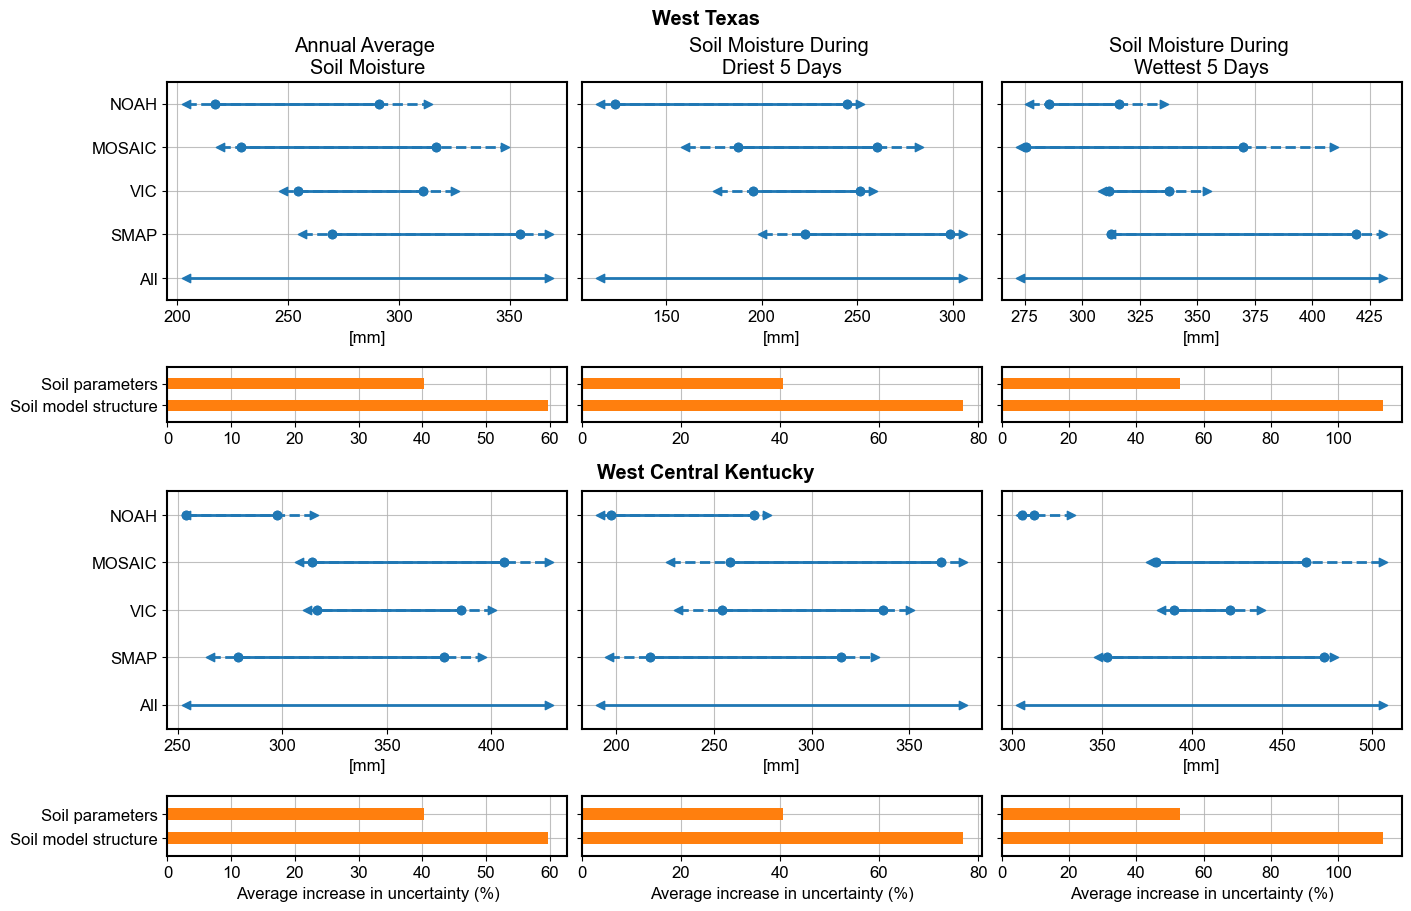

In [217]:
color_dist = "C0"
color_diff = "C1"
lw = 2

fig = plt.figure(layout='constrained', figsize=(14, 9))
subfigs = fig.subfigures(2, 1, wspace=0.15)

subfigs[0].suptitle('West Texas', fontweight='bold')
axsTop = subfigs[0].subplots(2,3, sharey='row', height_ratios=[4,1], gridspec_kw=dict(hspace=0.05))

subfigs[1].suptitle('West Central Kentucky', fontweight='bold')
axsBottom = subfigs[1].subplots(2,3, sharey='row', height_ratios=[4,1], gridspec_kw=dict(hspace=0.05))

# Plot all
for id, soil_metric in enumerate(soil_metrics):
    # LOC 1
    # Plot ranges
    plot_ranges_single(df=df_out_loc1, 
                       ax=axsTop[0,id],
                       soil_metric=soil_metric,
                       ylabels=True,
                       xlabel="[mm]",
                       title = soil_labels[id],
                       legend=False,
                       year_group=year_groups[0],
                       color=color_dist, lw=2)
    # Plot changes
    plot_increases(df=df_out_loc1,
                   ax=axsTop[1,id],
                   soil_metric=soil_metric,
                   color=color_diff,
                   xlabel=False)

    # LOC 2
    # Plot ranges
    plot_ranges_single(df=df_out_loc2, 
                       ax=axsBottom[0,id],
                       soil_metric=soil_metric,
                       ylabels=True,
                       xlabel="[mm]",
                       title = "",
                       legend=False,
                       year_group=year_groups[0],
                       color=color_dist, lw=2)
    # Plot changes
    plot_increases(df=df_out_loc1,
                   ax=axsBottom[1,id],
                   soil_metric=soil_metric,
                   color=color_diff,
                   xlabel=True)

plt.show()